# Adversarial Attacks on Neural Networks

In this notebook, we will be discussing the concept of adversarial attacks on neural networks. We will be using the MNIST dataset for this purpose. We will be using the PyTorch library for building the neural network and the Foolbox library for generating adversarial attacks.

## Introduction
Adversarial attacks are a type of attack where the attacker tries to fool the neural network by adding some noise to the input image. The neural network will classify the image incorrectly after adding the noise. The noise added to the image is called adversarial noise. The adversarial noise is generated in such a way that it is not visible to the human eye but it is enough to fool the neural network. In this notebook, we will be white-box attacks where the attacker has access to the neural network architecture and the weights, with intention of reducing the accuracy of the neural network.

In [26]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.preprocessing import minmax_scale
import cleverhans

## Dataset

We will be using the MNIST dataset for this purpose. The MNIST dataset consists of 28x28 grayscale images of handwritten digits from 0 to 9. The dataset has 60,000 training images and 10,000 testing images. We will be using the testing images for generating adversarial attacks.

In [27]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

Now we show sample images from the MNIST dataset.

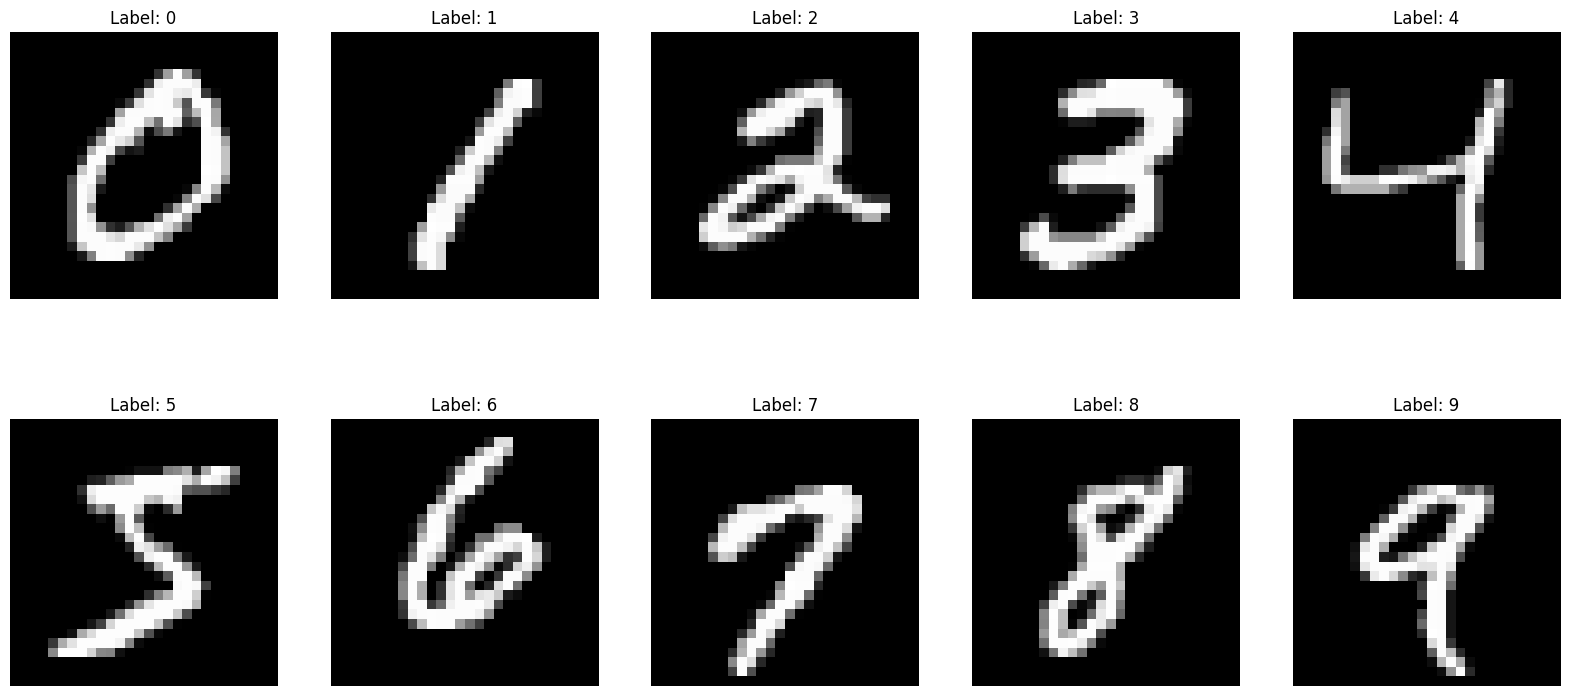

In [28]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=.01)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[y_train == i][0], cmap="gray")
    plt.title(f"Label: {str(i)}")
    plt.axis("off")

Now we check the distribution of the classes in the dataset.

In [29]:
def plot_hist(hist, title, ax: plt.Axes):
    ax.hist(
        y_train,
        bins=range(11),
        alpha=0.7,
        label="Train",
        color="blue",
        edgecolor="black",
        align="left",
    )
    ax.set_title(f"Digit distribution in The {title} Set")
    ax.set_xlabel("Digit")
    ax.set_ylabel("Frequency")
    ax.legend()

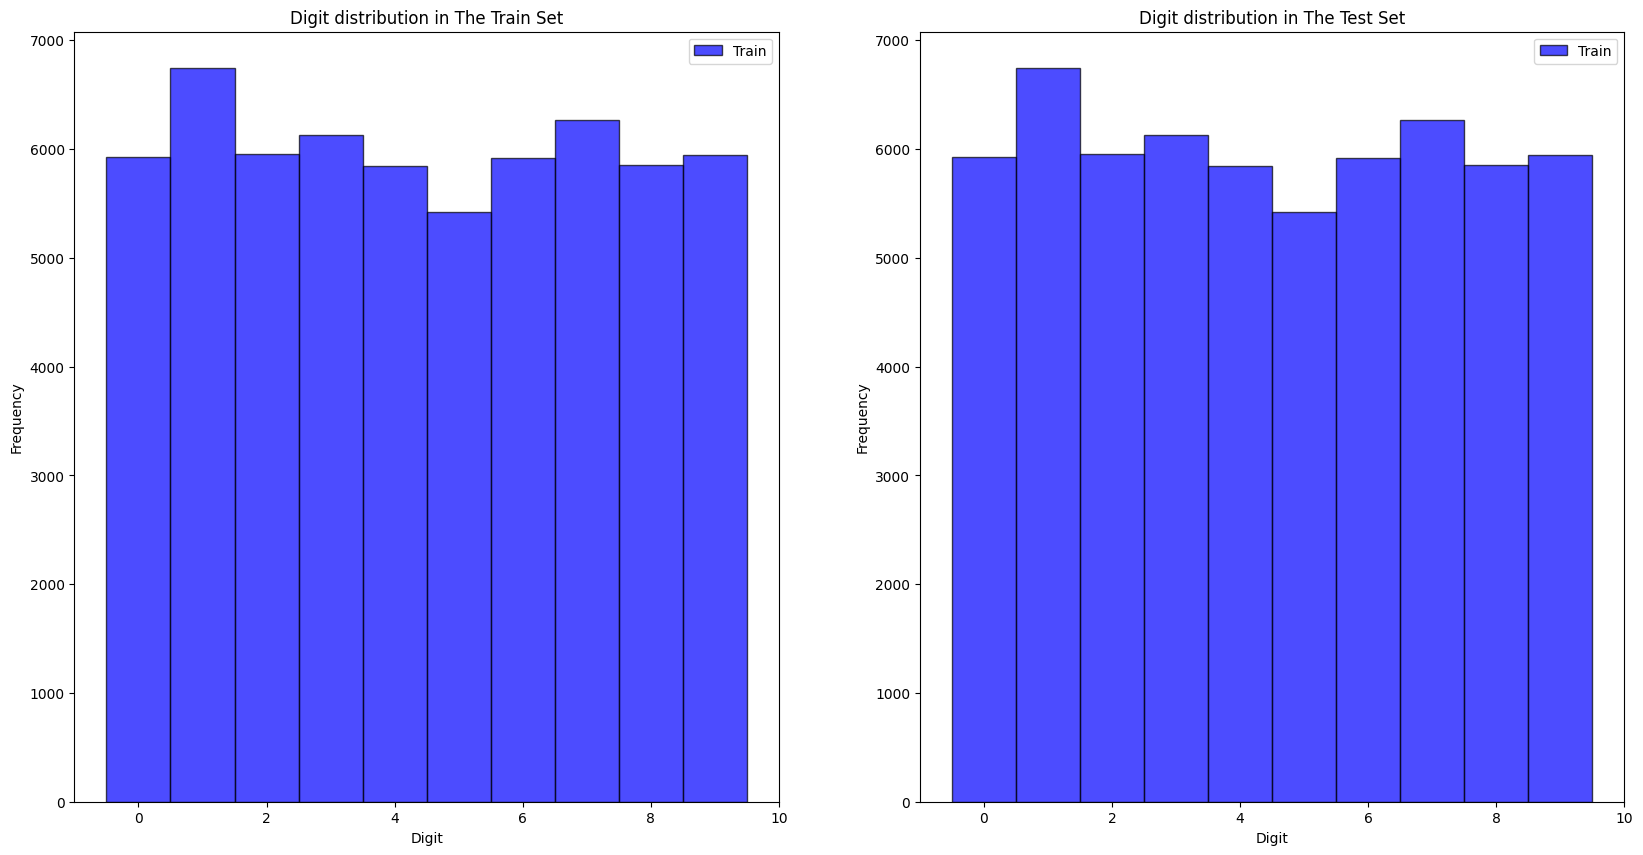

In [30]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))

plot_hist(y_train, "Train", ax[0])
plot_hist(y_test, "Test", ax[1])

As can be seen from the above plot, the dataset is somewhat balanced, so there is no need for us to balance the dataset.

Now by using min-max normalization, we normalize the pixel values of the images to the range [0, 1]. The reason for normalizing the pixel values is to make the training process faster and more stable. min-max normalization is done by subtracting the minimum pixel value and dividing by the maximum pixel value. More detailed reasons for normalization are as follows:

1. **Uniformity of scales**: Normalization ensures that all features contribute equally to the model's performance, regardless of their original scales. This is particularly important for algorithms that rely on distance metrics, such as k-nearest neighbors or support vector machines.

2. **Improved model performance**: Normalized data can enhance model performance and improve the accuracy of a model. It fosters stability in the optimization process, promoting faster convergence during gradient-based training.

3. **Prevention of numerical instability**: Normalization mitigates issues related to vanishing or exploding gradients, allowing models to reach optimal solutions more efficiently.

4. **Easier interpretation and visualization**: When all the features of a dataset are on the same scale, it becomes easier to identify and visualize the relationships between different features and make meaningful comparisons.


In [38]:
def print_sample_values(x):
    if len(x.shape) == 2:
        width, height = x.shape
        print("****" * width)
        for i in range(width):
            for j in range(height):
                print(f"{x[i, j]:3} ", end="") 
            print()
        print("****" * width)
    else:
        width, height = int(np.sqrt(x.shape[0])), int(np.sqrt(x.shape[0]))
        print("****" * width)
        for i in range(width):
            for j in range(height):
                print(f"{x[i * width + j]:3.2f} ", end="") if x[i * width + j] > 0 else print("    ", end="")
            print()
        print("****" * width)

In [32]:
sample_x = np.random.choice(x_train.shape[0])
print_sample_values(x_train[sample_x])

****************************************************************************************************************
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0  44 105 114 254 210  93   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0  22  60 148 229 253 253 253 253 248  99   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   8 188 253 253 254 253 253 253 249 149 112   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0  15 191 253 253 253 254 253 253 253 178   0   0   0   0   0 

In [33]:
# Reshape the images to 2D arrays
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# Apply min-max scaling to the train and test images
x_train_scaled = minmax_scale(x_train)
x_test_scaled = minmax_scale(x_test)

# Print the shape of the scaled train and test images
print("Scaled Train Images Shape:", x_train_scaled.shape)
print("Scaled Test Images Shape:", x_test_scaled.shape)


Scaled Train Images Shape: (60000, 784)
Scaled Test Images Shape: (10000, 784)


In [39]:
print_sample_values(x_train_scaled[sample_x])

****************************************************************************************************************
                                                                                                                
                                                                                                                
                                                                                                                
                                                                                                                
                                                        0.17 0.41 0.45 1.00 0.82 0.36                                 
                                            0.09 0.24 0.58 0.90 0.99 0.99 0.99 0.99 0.97 0.39                             
                                        0.03 0.74 0.99 0.99 1.00 0.99 0.99 0.99 0.98 0.58 0.44                             
                                    0.06 0.75 0.99 0.99 0.99 1.00 0.9